<a href="https://colab.research.google.com/github/atharvasatishchaudhari/Neural_Networks-/blob/main/Class_Activation_Maps%2C_LRs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:04<00:00, 35.7MB/s]


Epoch: 1 | Batch: 0 | Loss: 2.357
Epoch: 1 | Batch: 100 | Loss: 2.080
Epoch: 1 | Batch: 200 | Loss: 1.986
Epoch: 1 | Batch: 300 | Loss: 1.871
Epoch: 1 | Train Loss: 2.158 | Test Loss: 1.714 | Test Acc: 36.68%
Epoch: 2 | Batch: 0 | Loss: 1.808
Epoch: 2 | Batch: 100 | Loss: 1.592
Epoch: 2 | Batch: 200 | Loss: 1.636
Epoch: 2 | Batch: 300 | Loss: 1.513
Epoch: 2 | Train Loss: 1.688 | Test Loss: 1.696 | Test Acc: 39.46%
Epoch: 3 | Batch: 0 | Loss: 1.650
Epoch: 3 | Batch: 100 | Loss: 1.455
Epoch: 3 | Batch: 200 | Loss: 1.489
Epoch: 3 | Batch: 300 | Loss: 1.598
Epoch: 3 | Train Loss: 1.513 | Test Loss: 1.583 | Test Acc: 43.58%
Epoch: 4 | Batch: 0 | Loss: 1.410
Epoch: 4 | Batch: 100 | Loss: 1.348
Epoch: 4 | Batch: 200 | Loss: 1.343
Epoch: 4 | Batch: 300 | Loss: 1.133
Epoch: 4 | Train Loss: 1.375 | Test Loss: 1.225 | Test Acc: 55.94%
Epoch: 5 | Batch: 0 | Loss: 1.378
Epoch: 5 | Batch: 100 | Loss: 1.258
Epoch: 5 | Batch: 200 | Loss: 1.287
Epoch: 5 | Batch: 300 | Loss: 1.057
Epoch: 5 | Train Loss:

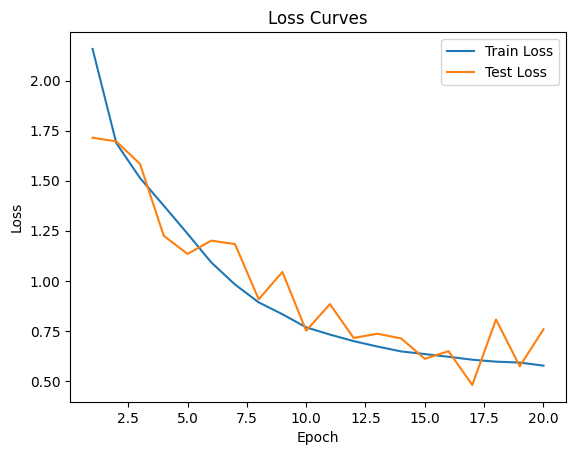

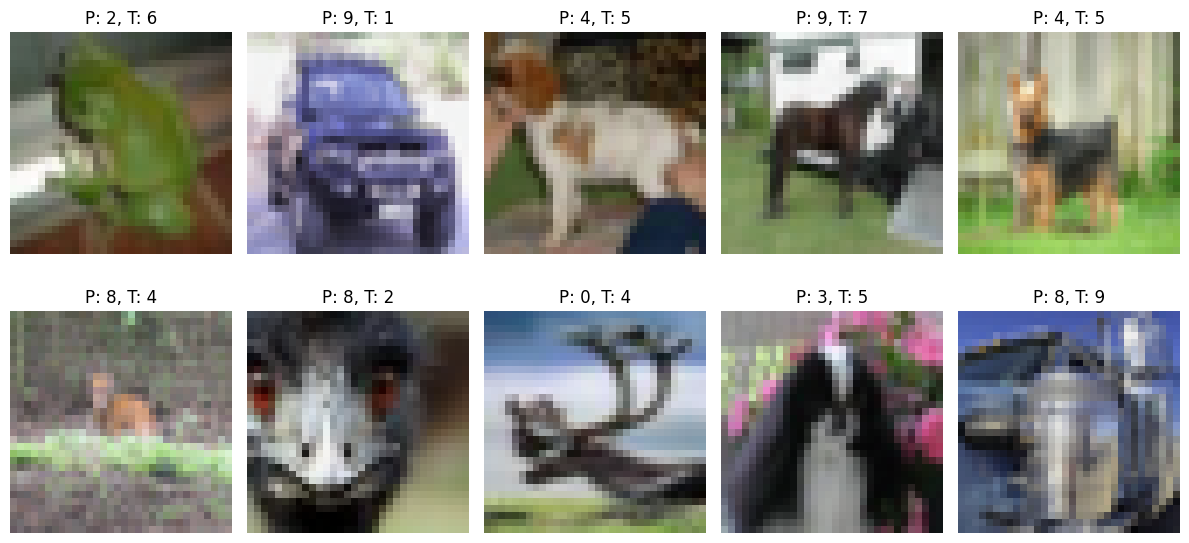

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


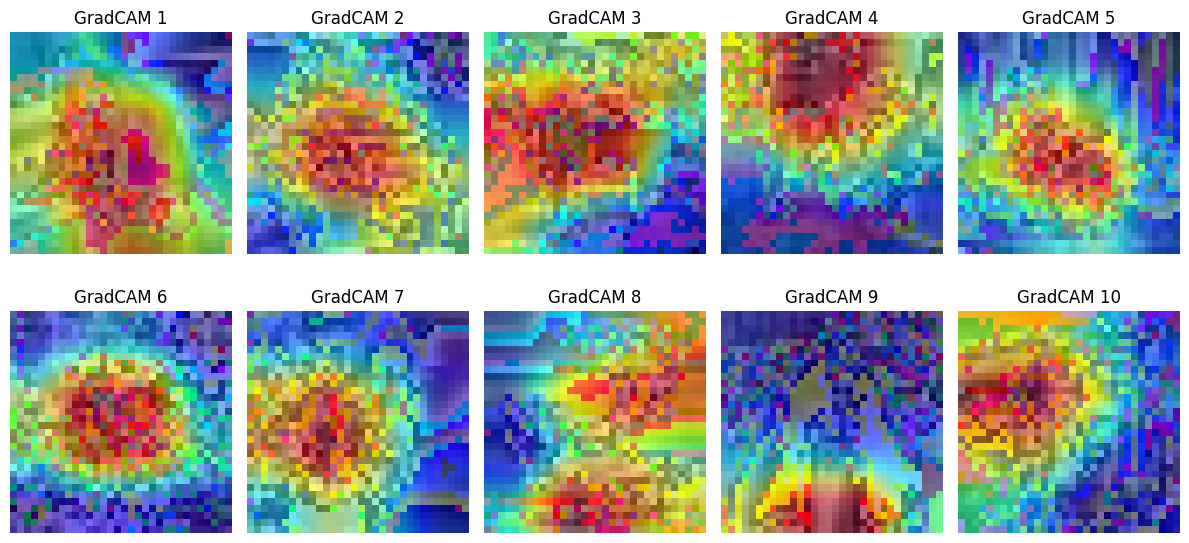

Training complete. Final Test Accuracy: 77.01%


In [1]:
# Merged Code for ResNet18 Training on CIFAR10 in Google Colab

import os
import cv2
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ===============================================================
#                1. MODEL: ResNet18 Definition
# ===============================================================

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

# ===============================================================
#                2. UTILS: Helper Functions
# ===============================================================

class Cutout(object):
    """Randomly mask out one or more patches from an image."""
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        # img is assumed to be a tensor of shape (C, H, W)
        h = img.size(1)
        w = img.size(2)
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        return img

def plot_loss_curves(train_losses, test_losses, epochs):
    plt.figure()
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.savefig('loss_curves.png')
    plt.show()
    plt.close()

def get_misclassified_images(misclassified, save_path, num_images=10):
    # Use only the first num_images misclassified images
    misclassified = misclassified[:num_images]

    # Denormalization for display
    inv_norm = transforms.Normalize(
        mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
        std=[1/0.2023, 1/0.1994, 1/0.2010]
    )
    plt.figure(figsize=(12, 6))
    for idx, (img, pred, target) in enumerate(misclassified):
        img = inv_norm(img)
        img = img.permute(1, 2, 0).numpy()
        plt.subplot(2, 5, idx + 1)
        plt.imshow(img.clip(0, 1))
        plt.title(f'P: {pred.item()}, T: {target.item()}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

def apply_gradcam(model, device, misclassified, save_path, num_images=10):
    """
    Applies GradCAM on a sample of misclassified images.
    This implementation hooks into the last convolutional layer (model.layer4).
    """
    from torchvision.transforms import ToPILImage
    import torch.nn.functional as F

    misclassified = misclassified[:num_images]
    features = []
    gradients = []

    def forward_hook(module, input, output):
        features.append(output.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    hook_handle1 = model.layer4.register_forward_hook(forward_hook)
    hook_handle2 = model.layer4.register_backward_hook(backward_hook)

    gradcam_images = []
    for img, pred, target in misclassified:
        img = img.unsqueeze(0).to(device)
        model.zero_grad()
        output = model(img)
        score = output[0, pred]
        score.backward(retain_graph=True)

        fmap = features[-1]
        grad = gradients[-1]

        weights = torch.mean(grad, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * fmap, dim=1)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.cpu().numpy()[0]
        cam = cv2.resize(cam, (32, 32))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        to_pil = ToPILImage()
        orig_img = to_pil(img.squeeze().cpu())
        orig_img = np.array(orig_img)
        overlay = cv2.addWeighted(orig_img, 0.5, heatmap, 0.5, 0)
        gradcam_images.append(overlay)

        features.clear()
        gradients.clear()

    hook_handle1.remove()
    hook_handle2.remove()

    plt.figure(figsize=(12, 6))
    for idx, gc_img in enumerate(gradcam_images):
        plt.subplot(2, 5, idx + 1)
        plt.imshow(gc_img)
        plt.title(f'GradCAM {idx + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

# ===============================================================
#                3. MAIN: Training and Evaluation
# ===============================================================

def get_data_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=16),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

def train(model, device, trainloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss.item():.3f}')
    avg_loss = running_loss / len(trainloader)
    return avg_loss

def test(model, device, testloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            # Save misclassified examples
            for i in range(len(targets)):
                if predicted[i] != targets[i]:
                    misclassified.append((inputs[i].cpu(), predicted[i].cpu(), targets[i].cpu()))
    avg_loss = test_loss / len(testloader)
    accuracy = 100. * correct / len(testloader.dataset)
    return avg_loss, accuracy, misclassified

def main():
    # Parse command-line arguments
    parser = argparse.ArgumentParser(description='ResNet18 CIFAR10 Training')
    parser.add_argument('--epochs', default=20, type=int, help='number of epochs')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
    parser.add_argument('--scheduler', action='store_true', help='use learning rate scheduler')
    args, unknown = parser.parse_known_args()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainloader, testloader = get_data_loaders(batch_size=args.batch_size)

    model = ResNet18(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) if args.scheduler else None

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(1, args.epochs + 1):
        train_loss = train(model, device, trainloader, criterion, optimizer, epoch)
        test_loss, test_accuracy, misclassified = test(model, device, testloader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f} | Test Acc: {test_accuracy:.2f}%')
        if scheduler:
            scheduler.step()

    # Plot and display loss curves
    plot_loss_curves(train_losses, test_losses, args.epochs)
    # Generate and display misclassified images gallery
    get_misclassified_images(misclassified, 'misclassified_gallery.png')
    # Generate and display GradCAM outputs on misclassified images
    apply_gradcam(model, device, misclassified, 'gradcam_outputs.png')

    os.makedirs('checkpoints', exist_ok=True)
    torch.save(model.state_dict(), 'checkpoints/resnet18_cifar10.pth')

    print(f"Training complete. Final Test Accuracy: {test_accuracies[-1]:.2f}%")

if __name__ == '__main__':
    main()
